This notebook uses quantum 

In [1]:
import os
import warnings

import pandas as pd
import numpy as np

from docplex.mp.model import Model


import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_auto

from qiskit.quantum_info import Pauli, Statevector, SparsePauliOp
from qiskit.circuit.library import pauli_two_design

from pauli_propagation import PauliTerm, PauliPropagator
from pauli_propagation.utils import encode_pauli


# Set matplotlib font and suppress warnings for cleaner output
plt.rcParams['font.family'] = 'DejaVu Sans'
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

In [2]:
# Map file names to tickers
ticker_map = {"Alphabet C Stock Price History.csv": "GOOG",
              "IBM Stock Price History.csv": "IBM",
              "Microsoft Stock Price History.csv": "MSFT",
              "Nvidia Stock Price History.csv": "NVDA"}
    
data_dir = "finance/stock_data"
all_dfs = []

# Read and standardize each file
for filename in ticker_map:
    ticker = ticker_map[filename]
    file_path = os.path.join(data_dir, filename)
    df = pd.read_csv(file_path, usecols=["Date", "Price"])
    df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
    df = df.sort_values("Date")
    df["Price"] = df["Price"].replace({",": ""}, regex=True).astype(float)
    df = df.rename(columns={"Price": ticker})
    all_dfs.append(df)

# Merge all dataframes
df_merged = all_dfs[0]
for df in all_dfs[1:]:
    df_merged = df_merged.merge(df, on="Date", how="inner")

# Remove duplicates and missing values
df_merged = df_merged.drop_duplicates(subset="Date").dropna().reset_index(drop=True)

df_merged

,Date,GOOG,IBM,MSFT,NVDA
0,2015-06-01,26.70,170.18,47.23,0.56
1,2015-06-02,26.96,169.65,46.92,0.55
2,2015-06-03,27.02,169.92,46.85,0.54
3,2015-06-04,26.84,168.38,46.36,0.55
4,2015-06-05,26.67,167.40,46.14,0.56
...,...,...,...,...,...
2511,2025-05-23,169.59,258.63,450.18,131.29
2512,2025-05-27,173.98,263.23,460.69,135.50
2513,2025-05-28,173.38,260.24,457.36,134.81
2514,2025-05-29,172.96,258.69,458.68,139.19


In [3]:
# Calculate return for each day

price_df = df_merged[["Date", "GOOG", "IBM", "MSFT", "NVDA"]].copy()
price_df = price_df.set_index("Date")
returns_df = price_df.pct_change().dropna()
returns_df
returns_df

,GOOG,IBM,MSFT,NVDA
Date,,,,
2015-06-02,0.009738,-0.003114,-0.006564,-0.017857
2015-06-03,0.002226,0.001592,-0.001492,-0.018182
2015-06-04,-0.006662,-0.009063,-0.010459,0.018519
2015-06-05,-0.006334,-0.005820,-0.004745,0.018182
2015-06-08,-0.012373,-0.012306,-0.008886,-0.035714
...,...,...,...,...
2025-05-23,-0.013897,0.001006,-0.010289,-0.011594
2025-05-27,0.025886,0.017786,0.023346,0.032066
2025-05-28,-0.003449,-0.011359,-0.007228,-0.005092


In [4]:
# Calculate historical mean return and covariance matrix

mu = returns_df.mean().values
print(mu)
cov_matrix = returns_df.cov()
cov_matrix

[0.0009112  0.00028908 0.00105269 0.00267971]


,GOOG,IBM,MSFT,NVDA
GOOG,0.000337,0.000107,0.000226,0.000311
IBM,0.000107,0.000243,0.000111,0.000154
MSFT,0.000226,0.000111,0.000294,0.000333
NVDA,0.000311,0.000154,0.000333,0.001002


In [5]:
# Calculate purchase price, budget, and maximum number of shares
price_vec = price_df.iloc[-1]        # purchase price
B = 2000                 # budget: 2000 usd
n_max = (B // price_vec).astype(int) # maximum number of shares can be bought for each stock

# Define other parameters
tickers = ["GOOG", "IBM", "MSFT", "NVDA"]
P = price_vec.values.astype(float)          # latest closing prices (shape N,)
P_prime = P / B                                  # P′  = P / B                                 # shape (N,)
Sigma = cov_matrix.values                      # shape (N,N)
d = np.floor(np.log2(n_max)).astype(int) # number of bits required to encode the optimisation problem
q = 0.5                                    # risk aversion parameter
lam = 10                             # penalty coefficient λ
N = len(tickers)

In [6]:
# --- C matrix ---
total_bits = int(np.sum(d + 1))
C = np.zeros((N, total_bits), dtype=int)

col = 0
for i in range(N):
    for k in range(d[i] + 1):
        C[i, col] = 2**k
        col += 1


C:\Users\woyao\AppData\Local\Temp\ipykernel_25336\2325697541.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for k in range(d[i] + 1):


In [7]:
mu_prime     = P_prime * mu                         # (N,)
Sigma_prime  = np.outer(P_prime, P_prime) * Sigma   # (N,N)
mu_dbl    = C.T @ mu_prime                  # (total_bits,)
Sigma_dbl = C.T @ Sigma_prime @ C           # (total_bits,total_bits)
P_dbl     = C.T @ P_prime                   # (total_bits,)
lin_coef = mu_dbl + 2 * lam * P_dbl                       # (total_bits,)
quad_coef = -q * Sigma_dbl - lam * np.outer(P_dbl, P_dbl) # (total_bits,total_bits)


In [8]:
# %%
# Create model and binary decision variables
mdl = Model(name="Portfolio_BB_hard_budget")
b_vars = mdl.binary_var_list(total_bits, name='b')

# Linear term: only the return term
lin_expr = mdl.sum(lin_coef[i] * b_vars[i] for i in range(total_bits))

# Recalculate quadratic term:
# Diagonal terms (no multiplication by 2)
quad_diag = mdl.sum(quad_coef[i, i] * b_vars[i] * b_vars[i] for i in range(total_bits))

# Off-diagonal terms need to be multiplied by 2
quad_off  = mdl.sum(2 * quad_coef[i, j] * b_vars[i] * b_vars[j]
                    for i in range(total_bits) for j in range(i+1, total_bits))

# Total quadratic term
quad_expr = quad_diag + quad_off

# ---- Maximize objective ----
mdl.maximize(lin_expr + quad_expr)

# ---- Solve ----
solution = mdl.solve(log_output=False)
assert solution is not None, "CPLEX did not find a feasible solution!"
print("Optimal objective value =", solution.objective_value)


Optimal objective value = 10.001817733654944


In [9]:
# Result Analysis and Validation 
# Retrieve the optimal binary vector b*
b_star = np.array([v.solution_value for v in b_vars]) # .round().astype(int)

# Recover the optimal integer number of shares n* and budget usage
n_star     = C @ b_star                         # shape (N,)
budget_use = np.dot(P, n_star)
print("Optimal integer shares n* =", n_star, "; Budget usage =", budget_use)

# Portfolio weights, expected return, and variance
x_star         = (P * n_star) / B
port_ret       = np.dot(mu, x_star)
port_var       = x_star @ Sigma @ x_star
port_volatility = np.sqrt(port_var)

print(f"Portfolio weights x*      = {x_star}")
print(f"Expected return (μ_p)     = {port_ret:.6%}")
print(f"Portfolio volatility (σ_p) = {port_volatility:.6%}")

# Budget constraint check
print("Budget deviation (abs(ΣPx - B)/B) =", abs(budget_use - B) / B)


Optimal integer shares n* = [ 3.  0.  0. 11.] ; Budget usage = 2004.9799999999998
Portfolio weights x*      = [0.259275 0.       0.       0.743215]
Expected return (μ_p)     = 0.222785%
Portfolio volatility (σ_p) = 2.638636%
Budget deviation (abs(ΣPx - B)/B) = 0.0024899999999998955


In [ ]:
# portfolio optimisation for various risk aversion factor k

q_range = np.linspace(0, 20, 500)  

results = []

# Iterate over different q values and compute the optimal portfolio for each q
for q in tqdm(q_range):
    # Recalculate lin_coef and quad_coef for each q
    lin_coef = mu_dbl + 2 * lam * P_dbl
    quad_coef = -q * Sigma_dbl - lam * np.outer(P_dbl, P_dbl)

    # Set up the model: generate different optimal portfolios by adjusting q
    mdl = Model(name="Portfolio_QUBO")
    b_vars = mdl.binary_var_list(total_bits, name='b')

    # Linear term: only the return term
    lin_expr = mdl.sum(lin_coef[i] * b_vars[i] for i in range(total_bits))

    # Recalculate quadratic term: diagonal terms
    quad_diag = mdl.sum(quad_coef[i, i] * b_vars[i] * b_vars[i] for i in range(total_bits))

    # Off-diagonal terms need to be multiplied by 2
    quad_off = mdl.sum(2 * quad_coef[i, j] * b_vars[i] * b_vars[j]
                        for i in range(total_bits) for j in range(i+1, total_bits))

    # Total quadratic term
    quad_expr = quad_diag + quad_off

    # ---- Maximize objective ----
    mdl.maximize(lin_expr + quad_expr)

    # ---- Solve ----
    solution = mdl.solve(log_output=False)
    if solution:
        # Parse b_star and results
        b_star = np.array([v.solution_value for v in b_vars]).round().astype(int)
        n_star = C @ b_star  # Get integer number of shares

        # Calculate portfolio weights, return, and variance
        x_star = (P * n_star) / B  # Investment weights
        port_ret = np.dot(mu, x_star)  # Expected return
        port_var = x_star @ Sigma @ x_star  # Variance
        port_volatility = np.sqrt(port_var)  # Volatility
        budget_use = np.dot(P, n_star)  # Budget used

        # Store results
        results.append({"q": q,
                        "n_star": n_star,
                        "x_star": x_star,
                        "port_ret": port_ret,
                        "port_volatility": port_volatility,
                        "budget_use": budget_use})
    

port_results_df = pd.DataFrame(results)

# Save the results DataFrame to a CSV file in the stock_data folder
classical_file_path = 'finance\optimisation_results\classical_qubo.csv'
port_results_df.to_csv(classical_file_path, index=False)

100%|██████████| 500/500 [00:34<00:00, 14.29it/s]


In [11]:
classical_file_path = 'finance\optimisation_results\classical_qubo.csv'
port_results_df = pd.read_csv(classical_file_path)
port_results_df

,q,n_star,x_star,port_ret,port_volatility,budget_use
0,0.000000,[ 0 2 0 11],[0. 0.25906 0. 0.743215],0.002066,0.025085,2004.55
1,0.040080,[ 3 0 0 11],[0.259275 0. 0. 0.743215],0.002228,0.026386,2004.98
2,0.080160,[ 3 0 0 11],[0.259275 0. 0. 0.743215],0.002228,0.026386,2004.98
3,0.120240,[ 3 0 0 11],[0.259275 0. 0. 0.743215],0.002228,0.026386,2004.98
4,0.160321,[ 3 0 0 11],[0.259275 0. 0. 0.743215],0.002228,0.026386,2004.98
...,...,...,...,...,...,...
495,19.839679,[3 4 1 0],[0.259275 0.51812 0.23018 0. ],0.000628,0.013633,2015.15
496,19.879760,[3 4 1 0],[0.259275 0.51812 0.23018 0. ],0.000628,0.013633,2015.15
497,19.919840,[3 4 1 0],[0.259275 0.51812 0.23018 0. ],0.000628,0.013633,2015.15
498,19.959920,[3 4 1 0],[0.259275 0.51812 0.23018 0. ],0.000628,0.013633,2015.15


## Quantum

In [12]:
# Build Ising coefficients h_k, J_{k,l} from classical QUBO -

def build_ising_from_classical(mu_dbl, Sigma_dbl, P_dbl, q, lam):
    """Calculate the coefficients required for the subsequent Ising model."""
    Q = q * Sigma_dbl + lam * np.outer(P_dbl, P_dbl)  # (M,M), symmetric
    a = mu_dbl + 2.0 * lam * P_dbl                    # (M,)
    # h_k
    h = 0.5 * (Q.sum(axis=1) - a)
    # J_{k,l} with upper triangle (k<l)
    # store as list of (k,l,J_kl) for convenience
    M = Q.shape[0]
    J_list = []
    for k in range(M):
        for l in range(k+1, M):
            J_list.append((k, l, 0.5 * Q[k, l]))
    return h, J_list

h, J_list = build_ising_from_classical(mu_dbl, Sigma_dbl, P_dbl, q, lam)
M = len(h)
M

14

In [13]:
#  Build PauliSum (list[PauliTerm]) for H = sum_k h_k Z_k + sum_{k<l} J_{k,l} Z_k Z_l 
def pauli_string_Z(n_qubits, positions):
    # positions: iterable of qubit indices where 'Z' acts, others 'I'
    s = ['I'] * n_qubits
    for p in positions:
        s[p] = 'Z'
    return ''.join(s)

def build_pauli_terms_from_ising(h, J_list):
    terms = []
    n = len(h)
    # single-Z terms
    for k, coeff in enumerate(h):
        if abs(coeff) > 0.0:
            label = Pauli(pauli_string_Z(n, [k]))
            key = encode_pauli(label)
            terms.append(PauliTerm(coeff, key, n))
    # ZZ couplings
    for (i, j, coeff) in J_list:
        if abs(coeff) > 0.0:
            label = Pauli(pauli_string_Z(n, [i, j]))
            key = encode_pauli(label)
            terms.append(PauliTerm(coeff, key, n))
    return terms

H_pauli_terms = build_pauli_terms_from_ising(h, J_list)

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not

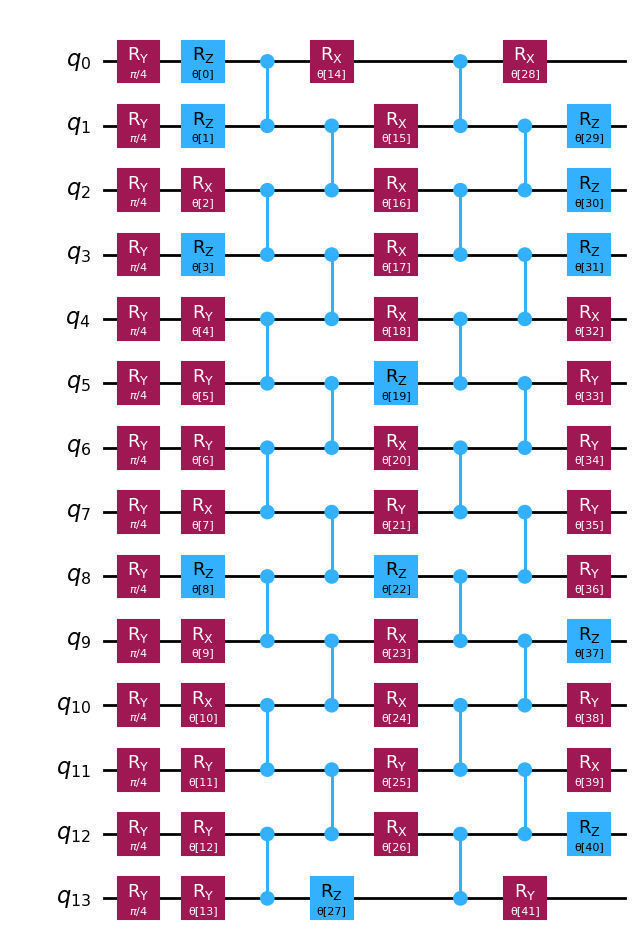

In [14]:

ansatz_qc = pauli_two_design(num_qubits=M, reps=2, seed=5)
ansatz_qc.draw("mpl");


In [15]:
# ----------  Define energy function via Pauli Propagation ----------
# Given H as a Pauli-term sum (H_pauli_terms) and a parametric ansatz circuit built by
# qiskit.circuit.library.pauli_two_design, compute E(theta) = <psi(theta)| H |psi(theta)>,
# where the product label "0"*M corresponds to |+>^M in your tutorial.


prop = PauliPropagator(ansatz_qc)

def energy_from_pp(theta_values, max_weight= 5, product_label=None):
    # product_label: string with length M; "0"*M equals |+>^M in your API.
    if product_label is None:
        product_label = "0" * M

    bound_qc = ansatz_qc.assign_parameters(theta_values, inplace=False)

    local_prop = PauliPropagator(bound_qc)
    # Propagate the Hamiltonian (sum of PauliTerm) through the bound circuit
    prop_result = local_prop.propagate(H_pauli_terms, max_weight=max_weight, history=False, show_progress = False)
    # Return the expectation value
    E = local_prop.expectation_pauli_sum(prop_result, product_label)
    return float(E)

# Quick smoke-test at random parameters
_ = np.random.default_rng(0)
theta_test = _.standard_normal(ansatz_qc.num_parameters)
test_E = energy_from_pp(theta_test)
print("Test energy (random thetas) =", test_E)

Test energy (random thetas) = 23.117949036726873


In [16]:
# Build the full observable once, then reuse it every energy call.
# This avoids looping over Pauli strings on every evaluation.

def label_Z(n_qubits, positions):
    s = ['I'] * n_qubits
    for k in positions:
        # s[n_qubits - 1 - k] = 'Z'  # flip index
        s[k] = 'Z'  
    return ''.join(s)

def build_sparse_H(n_qubits, h, J_list):
    """Build H = sum_k h_k Z_k + sum_{i<j} J_ij Z_i Z_j as a SparsePauliOp."""
    labels, coeffs = [], []

    # single-Z terms
    for k, hk in enumerate(h):
        if hk != 0.0:
            labels.append(label_Z(n_qubits, [k]))
            coeffs.append(float(hk))

    # ZZ terms
    for (i, j, Jij) in J_list:
        if Jij != 0.0:
            labels.append(label_Z(n_qubits, [i, j]))
            coeffs.append(float(Jij))

    return SparsePauliOp.from_list(list(zip(labels, coeffs)))

# Build once (global). Do NOT rebuild inside the energy function.
H_sparse = build_sparse_H(ansatz_qc.num_qubits, h, J_list)

def energy_from_sv(theta_values):
    """
    Fast energy evaluation with Statevector.
    Uses the pre-built parametric circuit `ansatz_qc` and a pre-built SparsePauliOp `H_sparse`.
    Starts from |0>^n.
    """
    n = ansatz_qc.num_qubits

    # Bind parameters without mutating the original circuit
    bound = ansatz_qc.assign_parameters(theta_values, inplace=False)

    # Evolve |0>^n through the bound ansatz
    sv0 = Statevector.from_label('0' * n)
    svf = sv0.evolve(bound)

    # Single-shot expectation for the whole observable
    E = svf.expectation_value(H_sparse)

    # Return a real scalar (strip negligible imaginary part)
    return float(np.real_if_close(E))

# Smoke test
rng = np.random.default_rng(0)
theta_test = rng.standard_normal(ansatz_qc.num_parameters)
print("Test energy (random thetas) =", energy_from_sv(theta_test))


Test energy (random thetas) = 23.328725109950366


In [17]:
# Classical optimizer: lightweight SPSA with early stopping 

def spsa_optimize(
    energy_fn,
    theta0,
    maxiter=100,
    a0=0.1,
    c0=0.1,
    alpha=0.602,
    gamma=0.101,
    seed=123,
    callback=None,
    early_stop_tol=1e-6,
    early_stop_patience=10,
    show_progress=True):
    
    rng = np.random.default_rng(seed)
    theta = np.asarray(theta0, dtype=float).copy()

    # initial energy

    best_E = energy_fn(theta)
    no_improve = 0

    it = tqdm(range(1, maxiter + 1), disable=(not show_progress))
    for t in it:
        a_t = a0 / (t ** alpha)
        c_t = c0 / (t ** gamma)

        delta = rng.choice((-1.0, 1.0), size=theta.shape)

        # two evals for SPSA gradient

        Ep = energy_fn(theta + c_t * delta)
        Em = energy_fn(theta - c_t * delta)

        ghat = (Ep - Em) / (2.0 * c_t) * delta
        theta -= a_t * ghat

        # current energy

        E_curr = energy_fn(theta)

        if best_E - E_curr > early_stop_tol:
            best_E = E_curr
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= early_stop_patience:
                if not it.disable:
                    it.write(f"[Early Stop] Iter {t}: no significant improvement for {early_stop_patience} steps.")
                break

        if not it.disable:
            it.set_postfix_str(f"E={E_curr:.7g}, best={best_E:.7g}")

        if callback is not None and (t == 1 or t == maxiter or t % 10 == 0):
            callback(t, theta, Ep, Em)

    return theta



In [18]:
# # optimise with state vector

# # Run SPSA with early stopping
# theta_opt_sv = spsa_optimize(
#     energy_from_sv,
#     theta_test,
#     maxiter=100,
#     early_stop_tol=1e-4,
#     early_stop_patience=15)

# print("Optimized energy =", energy_from_sv(theta_opt_sv))

In [19]:
# # # optimise with pauli prop

# # Run SPSA with early stopping
# theta_opt_pp = spsa_optimize(
#     energy_from_pp,
#     theta_test,
#     maxiter=200,
#     early_stop_tol=1e-4,
#     early_stop_patience=15)

# print("Optimized energy =", energy_from_pp(theta_opt_pp))

In [20]:
theta_opt_pp = np.array([-3.92729840e+00, -3.04169439e+00,  5.71832557e-02, -1.99330518e+00,
       -8.31704274e-01, -2.43932882e-01, -1.62007822e+00, -2.38106221e+00,
       -3.48427450e+00, -3.14788152e+00, -2.53658726e+00,  1.05918223e-01,
       -5.63662712e+00, -7.36306073e-02, -4.18627885e+00,  5.66505068e-03,
       -3.86608975e+00,  2.59424516e+00,  6.94124339e-01,  5.70312339e+00,
        1.63414500e-01,  3.11635220e+00, -3.05528144e+00, -6.91742718e-02,
       -2.29896117e+00,  2.75582610e+00, -4.31911625e+00, -3.92449438e-01,
        3.15298626e+00,  3.99760295e-01, -2.88391880e+00,  1.73006911e+00,
       -3.47932008e+00,  2.68045920e+00,  2.30775970e+00, -2.17252651e+00,
        3.70394677e+00,  3.94081597e-01,  4.60332503e+00,  9.21449842e-01,
       -5.15545779e+00,  6.55232030e+00])

In [21]:

# Pre-build Z operators once (one per qubit), reuse in each call.
Z_OPS = [SparsePauliOp.from_list([(label_Z(ansatz_qc.num_qubits, [k]), 1.0)])
         for k in range(ansatz_qc.num_qubits)]

def estimate_Z_expectations(theta_values, qubit_ids=None):
    """
    Estimate <Z_k> for |psi(theta)> prepared by `ansatz_qc`.
    Initial state is |0>^n to match energy_from_sv; if you need |+>^n, add H-gates to ansatz outside.
    """
    n = ansatz_qc.num_qubits
    if qubit_ids is None:
        qubit_ids = range(n)

    # Bind parameters without mutating the original circuit
    bound = ansatz_qc.assign_parameters(theta_values, inplace=False)

    # Prepare |0>^n and evolve
    sv = Statevector.from_label('0' * n).evolve(bound)

    # Compute <Z_k> for requested qubits
    Z_vals = np.zeros(n, dtype=float)
    for k in qubit_ids:
        Z_vals[k] = float(np.real_if_close(sv.expectation_value(Z_OPS[k])))
    return Z_vals

# Z_exp = estimate_Z_expectations(theta_opt_sv)
Z_exp = estimate_Z_expectations(theta_opt_pp)
b_hat = np.round((1 +Z_exp)/2)


In [22]:
# map to integer shares and evaluate portfolio
n_star_q = (C @ b_hat).astype(int)
budget_use_q = float(P @ n_star_q)
x_star_q = (P * n_star_q) / B
port_ret_q = float(mu @ x_star_q)
port_var_q = float(x_star_q @ Sigma @ x_star_q)
port_vol_q = float(np.sqrt(port_var_q))

print("Recovered b* (after repair) =", b_hat.astype(int))
print("n* (shares) =", n_star_q, "; budget used =", budget_use_q)
print(f"mu_p (expected return) = {port_ret_q:.6%}")
print(f"sigma_p (volatility)   = {port_vol_q:.6%}")
print("Budget deviation       =", abs(budget_use_q - B) / B)

Recovered b* (after repair) = [1 0 0 0 0 0 0 0 0 0 0 0 1 1]
n* (shares) = [ 1  0  0 12] ; budget used = 1794.4099999999999
mu_p (expected return) = 0.225141%
sigma_p (volatility)   = 2.655144%
Budget deviation       = 0.10279500000000007


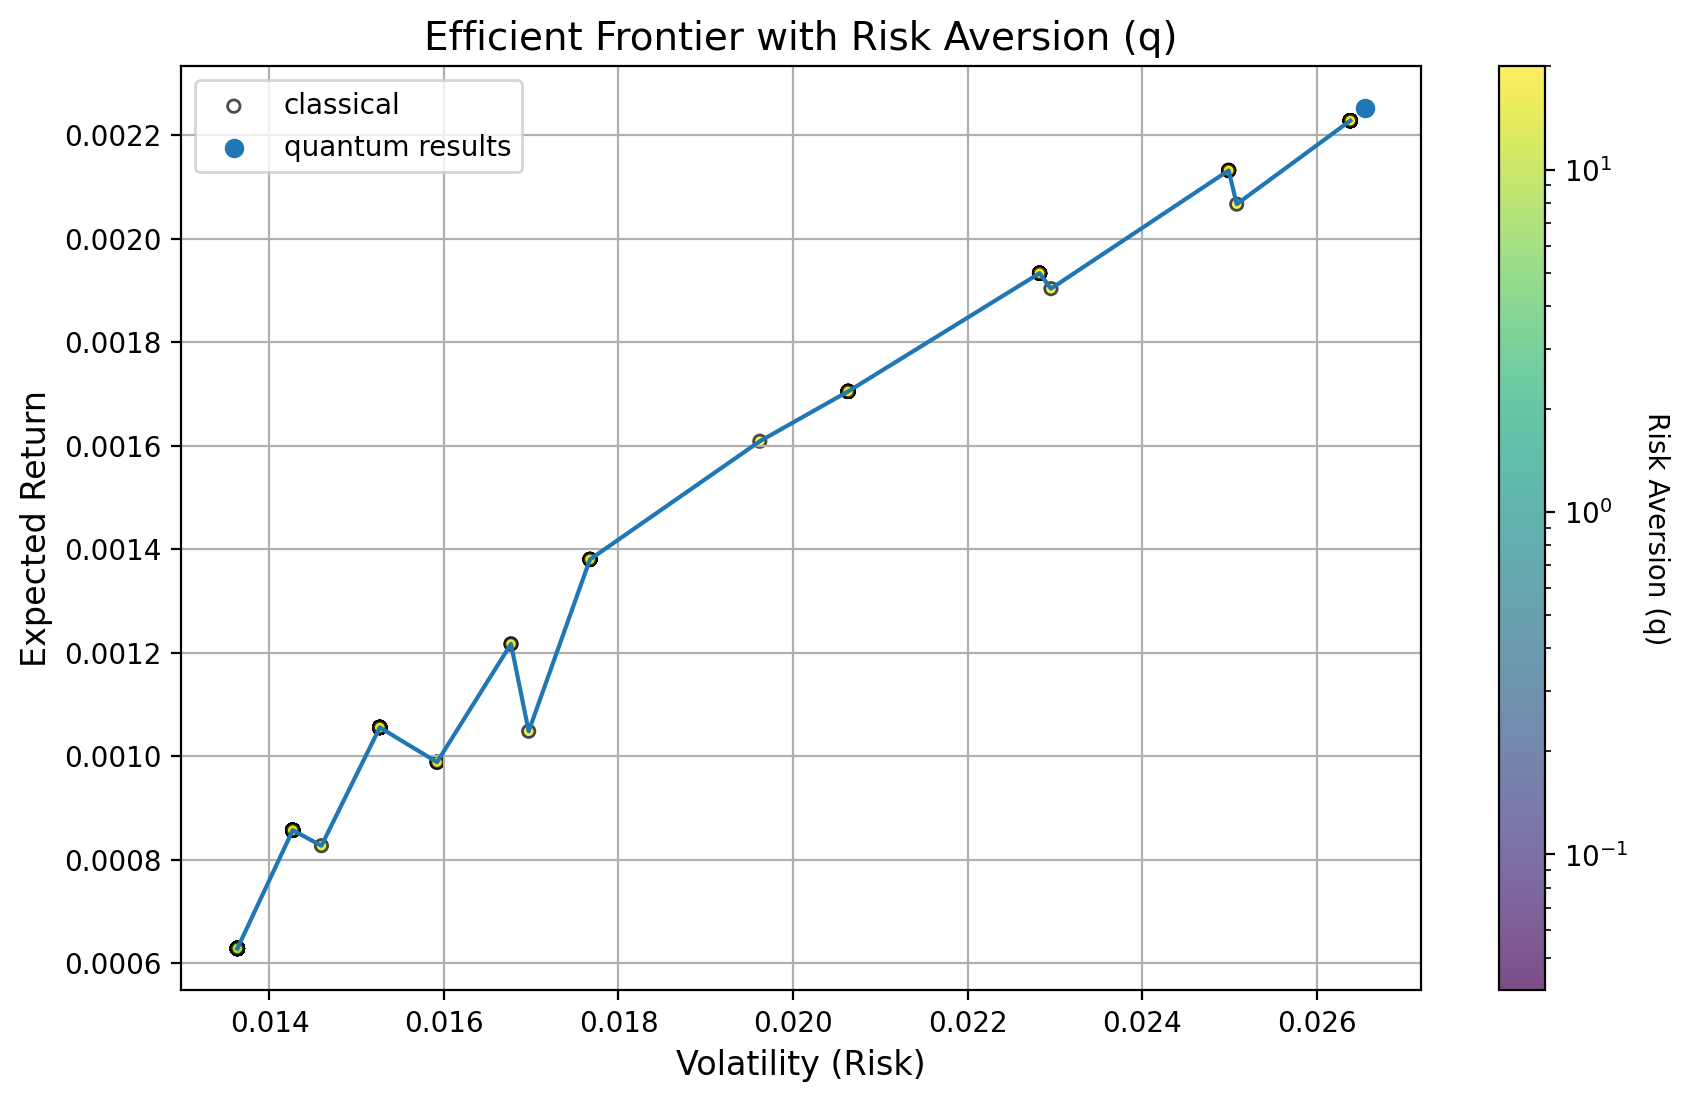

In [23]:
returns = port_results_df['port_ret']
volatilities = port_results_df['port_volatility']
q_values = port_results_df['q']  
plt.figure(figsize=(10, 6), dpi=200)

order = volatilities.argsort()

volatilities = volatilities.iloc[order]
returns = returns.iloc[order]

scatter = plt.scatter(volatilities, returns, c=q_values, cmap='viridis', s=20, 
                      edgecolors='k', alpha=0.7, norm=LogNorm(), label = 'classical')
plt.scatter(port_vol_q, port_ret_q, label = 'quantum results')

cbar = plt.colorbar(scatter)
cbar.set_label('Risk Aversion (q)', rotation=270, labelpad=15)

scatter = plt.plot(volatilities, returns)
plt.title("Efficient Frontier with Risk Aversion (q)", fontsize=14)
plt.xlabel("Volatility (Risk)", fontsize=12)
plt.ylabel("Expected Return", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()
